Source
https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
import datetime
import IPython
import IPython.display

import collections

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

# Data preperation

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

### Create data frame from input file

In [3]:
df = pd.read_csv('building_data.csv').interpolate()
df['Time'] = pd.to_datetime(df['Time'], infer_datetime_format=True)

In [4]:
df

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Office_Elizabeth,Office_Ellie,Office_Evelyn,Office_Eileen,Office_Bobbi,Office_Benjamin,Office_Bianca,Office_Benthe,Office_Brian,Office_Bryon
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,3.163383,6.970150,240.968342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,3.170692,6.780483,142.524367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,3.186217,6.970150,160.405408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,3.159733,6.685650,155.820508,NaN,41.775,44.75,19.56675,142.25,73.82075,273.150
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,3.167025,6.922733,150.711650,NaN,42.525,42.25,17.51600,143.00,74.88975,267.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,11.650250,31.958475,272.997017,64.280192,46.025,54.00,19.69750,135.50,79.16700,238.175
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.050,54.00,18.84550,137.00,79.64075,244.500
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,46.450,53.25,19.05500,138.25,79.99925,246.450
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.075,54.00,20.61675,141.50,85.80275,238.500


### Create aggregated data frame

In [5]:
df["Power consumption (kWh)"] = df.iloc[:,5:].mean(axis=1, skipna=True)
aggregated = df.drop(df.columns[5:-1], axis=1)

In [6]:
# Swap order so that
aggregated = aggregated.reindex(['Time', 'Day', 'Price( $ per kWh)', 'PV (W)', 'Temperature in LA in 2012 (Celsius)', 'Power consumption (kWh)'], axis=1)

In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

aggregated = filter_rows_by_values(aggregated, "Power consumption (kWh)", [0])


In [8]:
aggregated

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,83.700625
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,50.825181
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,56.853925
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,84.553155
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,83.211906
...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,95.345043
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,96.461049
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,97.002849
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,97.106874


### Add time variables

In [9]:
aggregated.insert(2, 'Day of Week', aggregated['Day'], True)
aggregated.insert(1, 'Year', aggregated['Time'].map(lambda x: x.year), True)
aggregated.insert(2, 'Day of Year', aggregated['Time'].map(lambda x: x.dayofyear), True)
aggregated.drop('Day', axis=1, inplace=True)
aggregated.insert(3, 'Hour', aggregated['Time'].map(lambda x: x.hour), True)

In [10]:
aggregated

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,2012,1,5,Sunday,0.08283,0.000,11.1,83.700625
1,2012-01-01 06:00:00+00:00,2012,1,6,Sunday,0.08283,0.000,10.0,50.825181
2,2012-01-01 07:00:00+00:00,2012,1,7,Sunday,0.08283,0.000,10.0,56.853925
3,2012-01-01 08:00:00+00:00,2012,1,8,Sunday,0.08283,743.711,10.0,84.553155
4,2012-01-01 09:00:00+00:00,2012,1,9,Sunday,0.08283,1479.480,10.0,83.211906
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,2012,366,19,Monday,0.09690,0.000,14.4,95.345043
8775,2012-12-31 20:00:00+00:00,2012,366,20,Monday,0.09690,0.000,15.0,96.461049
8776,2012-12-31 21:00:00+00:00,2012,366,21,Monday,0.08283,0.000,15.0,97.002849
8777,2012-12-31 22:00:00+00:00,2012,366,22,Monday,0.08283,0.000,15.0,97.106874


### Plot Features

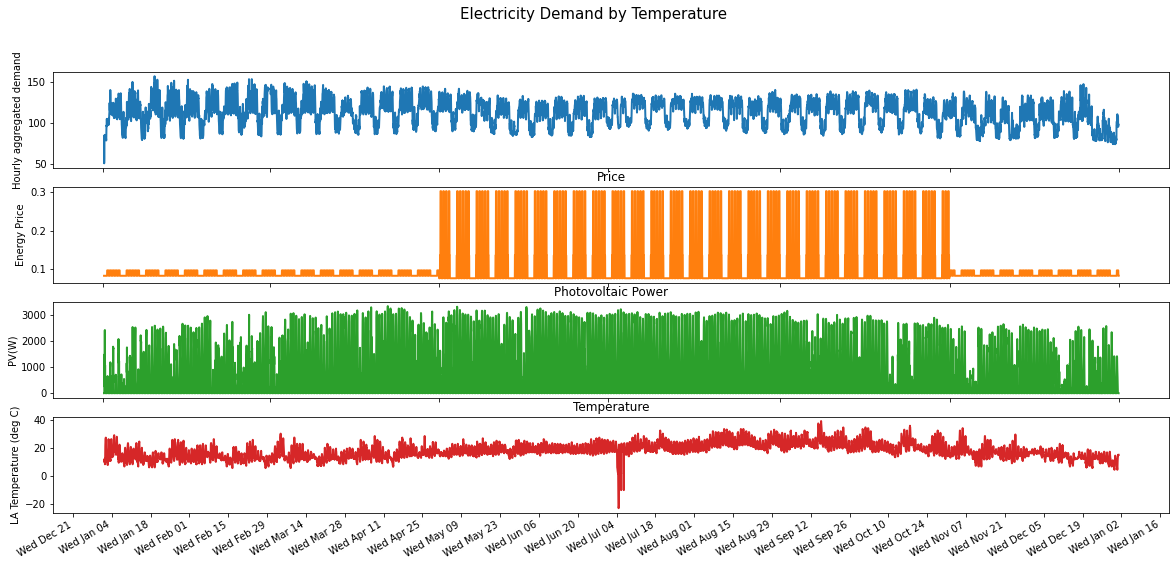

In [11]:
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE, interval=2)
demand_fmt = mdates.DateFormatter('%a %b %d')

colors = sns.color_palette()
c1, c2, c3, c4 = colors[0], colors[1], colors[2], colors[3]

fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(4, 1, 1)
ax.plot(aggregated.loc[:,'Time'],
        aggregated.loc[:,'Power consumption (kWh)'], lw=2, label="data set")
ax.set_ylabel("Hourly aggregated demand")

ax = fig.add_subplot(4, 1, 2)

ax.plot(aggregated.loc[:,'Time'],
        aggregated.loc[:,'Price( $ per kWh)'], lw=2, label="data set", c=c2)
ax.set_ylabel("Energy Price")
ax.set_title("Price")

ax = fig.add_subplot(4, 1, 3)

ax.plot(aggregated.loc[:,'Time'],
        aggregated.loc[:,'PV (W)'], lw=2, label="data set", c=c3)
ax.set_ylabel("PV(W)")
ax.set_title("Photovoltaic Power")

ax = fig.add_subplot(4, 1, 4)

ax.plot(aggregated.loc[:,'Time'],
        aggregated.loc[:,'Temperature in LA in 2012 (Celsius)'], lw=2, label="data set", c=c4)
ax.set_ylabel("LA Temperature (deg C)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand by Temperature",
             fontsize=15)
fig.autofmt_xdate()

### Encode and Scale data

In [12]:
# encode categorical data
encoder = LabelEncoder()
encoding_columns = ["Day of Week"]
for column in encoding_columns:
    aggregated[column] = encoder.fit_transform(aggregated[column]).astype('float32')

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
# these columns are NOT scaled
scalable_columns = aggregated.columns.difference(["Time"])
aggregated[scalable_columns] = scaler.fit_transform(aggregated[scalable_columns])

### Resulting prepared data

In [14]:
prepared_data = aggregated.reset_index(inplace=False, drop=True)
prepared_data

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,0.0,0.0,0.217391,0.500000,0.028415,0.000000,0.549433,0.309313
1,2012-01-01 06:00:00+00:00,0.0,0.0,0.260870,0.500000,0.028415,0.000000,0.531605,0.000000
2,2012-01-01 07:00:00+00:00,0.0,0.0,0.304348,0.500000,0.028415,0.000000,0.531605,0.056722
3,2012-01-01 08:00:00+00:00,0.0,0.0,0.347826,0.500000,0.028415,0.223776,0.531605,0.317334
4,2012-01-01 09:00:00+00:00,0.0,0.0,0.391304,0.500000,0.028415,0.445162,0.531605,0.304715
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,0.0,1.0,0.826087,0.166667,0.090592,0.000000,0.602917,0.418871
8775,2012-12-31 20:00:00+00:00,0.0,1.0,0.869565,0.166667,0.090592,0.000000,0.612642,0.429371
8776,2012-12-31 21:00:00+00:00,0.0,1.0,0.913043,0.166667,0.028415,0.000000,0.612642,0.434469
8777,2012-12-31 22:00:00+00:00,0.0,1.0,0.956522,0.166667,0.028415,0.000000,0.612642,0.435447


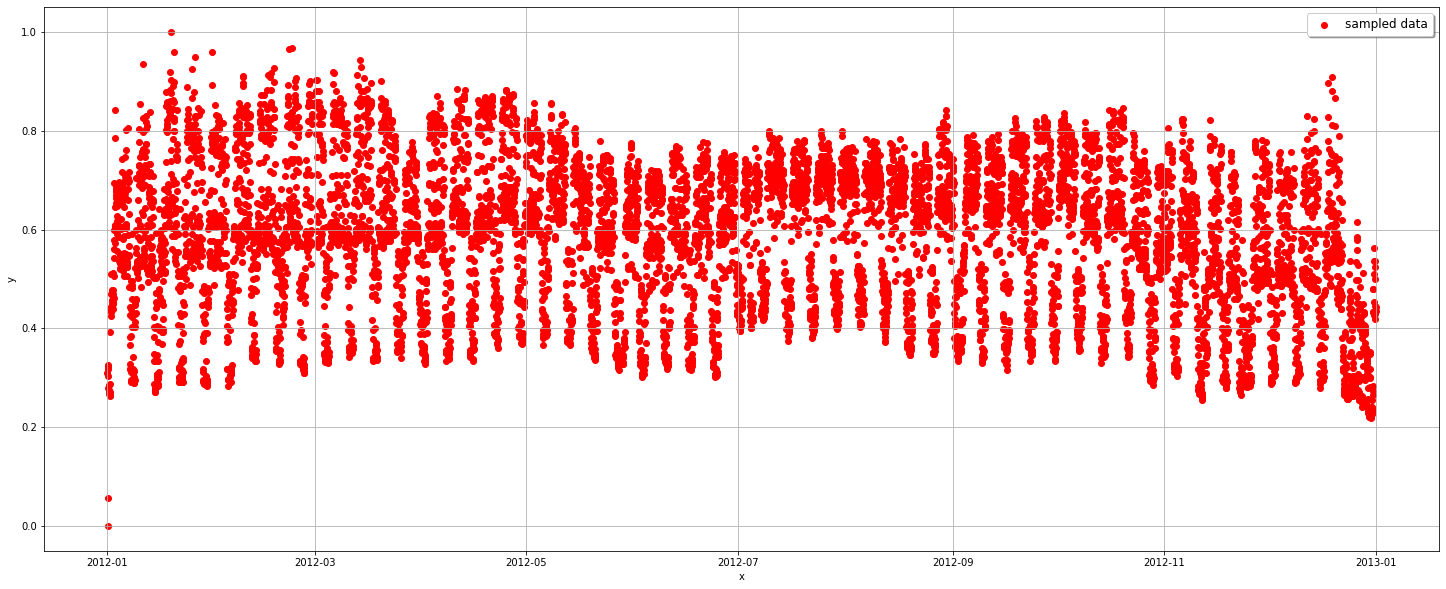

In [15]:
# Graph of prepared data (graph repeated later)
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(prepared_data.loc[:,'Time'],prepared_data.loc[:,'Power consumption (kWh)'],c="r",label='sampled data')
ax.legend(fontsize='large',shadow=True, bbox_to_anchor=(1, 1))
plt.show()

# Model Tools

## Imports

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
from sklearn.utils import shuffle
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input

## Constants

In [17]:
MEASURE_COLUMN_NAME = "Day of Year"
TRAINING_DATA_DECIMAL = 0.7
VALIDATION_DATA_DECIMAL = 0.2
TEST_DATA_DECIMAL = 0.1

In [18]:
# The number of timesteps to be used as input
INPUT_STEP_COUNT = 24 # input_width
# The number of timesteps to be used as output
OUTPUT_STEP_COUNT = 24 # label_width
# The column(s) to be predicted
OUTPUT_COLUMN_NAMES = ["Power consumption (kWh)"] # label_columns
PRIMARY_OUTPUT_COLUMN = OUTPUT_COLUMN_NAMES[0]

In [19]:
# The column(s) to ignore
IGNORE_COLUMN_NAMES = ["Year", "Time"]

In [20]:
NUM_FEATURES = 7

## Window Generator

#### Helper Functions

In [21]:
if not np.isclose(TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL + TEST_DATA_DECIMAL, 1, rtol=1e-05, atol=1e-08, equal_nan=False):
    raise ValueError('Invalid data decimals')

def errorIfDecimalInvalid(decimal):
    if decimal < 0 or decimal > 1:
        raise ValueError('Reached invalid decimal')
        
def isTraining(decimal):
    errorIfDecimalInvalid(decimal)
    return (decimal < 0.7)

def isValidationOrTest(decimal):
    return isValidation(decimal) or isTest(decimal)
    
def isValidation(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and decimal < TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL)

def isTest(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and not isValidation(decimal))

### Format data

In [22]:
time_series_data = prepared_data.copy()

In [23]:
time_series_data.drop(IGNORE_COLUMN_NAMES, axis=1, inplace=True)

#### Handle Time column (not in use)

In [24]:
# date_time = pd.to_datetime(time_series_data.pop('Time'), format='%d.%m.%Y %H:%M:%S')
# timestamp_s = date_time.map(pd.Timestamp.timestamp)

# day = 24*60*60
# year = (365.2425)*day

# time_series_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# time_series_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# time_series_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# time_series_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#### Declare variables

In [25]:
column_indices = {name: i for i, name in enumerate(time_series_data.columns)}

In [26]:
training_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTraining)]
val_or_test_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isValidationOrTest)]
validation_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isValidation)]
test_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTest)]

In [27]:
training_dataframe

,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,0.00000,0.217391,0.5,0.028415,0.000000,0.549433,0.309313
1,0.00000,0.260870,0.5,0.028415,0.000000,0.531605,0.000000
2,0.00000,0.304348,0.5,0.028415,0.000000,0.531605,0.056722
3,0.00000,0.347826,0.5,0.028415,0.223776,0.531605,0.317334
4,0.00000,0.391304,0.5,0.028415,0.445162,0.531605,0.304715
...,...,...,...,...,...,...,...
6134,0.69863,0.826087,1.0,0.262628,0.000000,0.784441,0.674048
6135,0.69863,0.869565,1.0,0.262628,0.000000,0.784441,0.668349
6136,0.69863,0.913043,1.0,0.000000,0.000000,0.756888,0.739311
6137,0.69863,0.956522,1.0,0.000000,0.000000,0.739060,0.688067


### Window Class

#### Class definition

In [28]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=training_dataframe, val_df=validation_dataframe, test_df=test_dataframe,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

#### Split window function

In [29]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

#### Plot function

In [30]:
def plot(self, model=None, plot_col=PRIMARY_OUTPUT_COLUMN, max_subplots=3, model_uses_labels=False, univariate=False):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col[0:10]}. [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            if model_uses_labels:
                predictions = model(inputs, labels)
            else:
                predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :] if univariate else predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### Make dataset function

In [31]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # TODO: Review the options for timeseries_dataset_from_array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

#### Accessor methods

In [32]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Training Functions

In [33]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

In [34]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


# Window Initialization

### Multi Step window

2021-11-10 03:00:16.133117: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-10 03:00:16.385527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

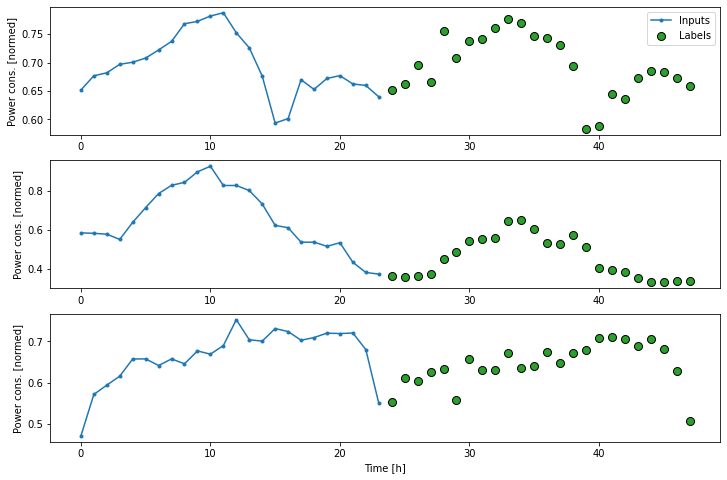

In [35]:
OUT_STEPS = OUTPUT_STEP_COUNT
multi_window = WindowGenerator(input_width=INPUT_STEP_COUNT,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Univariate Multi Step window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Power consumption (kWh)']

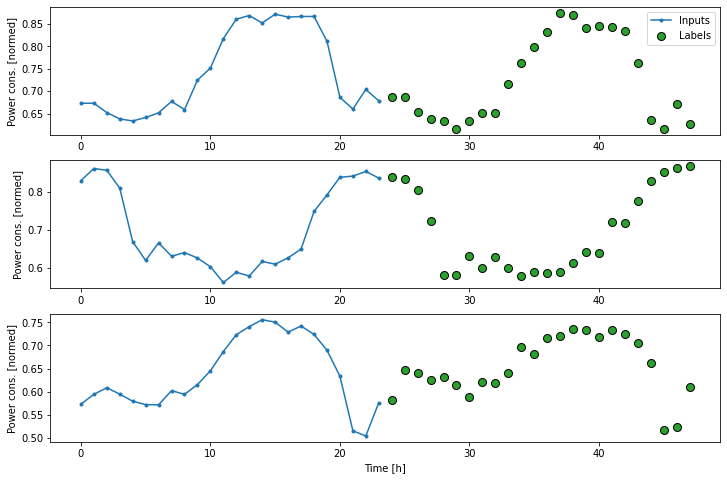

In [36]:
uni_multi_window = WindowGenerator(input_width=INPUT_STEP_COUNT,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=OUTPUT_COLUMN_NAMES)

uni_multi_window.plot()
uni_multi_window

# TF Probability

https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb

## Helper Functions

In [68]:
def plot_forecast(x, y, forecast_steps,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    
    ax.plot(x, y, lw=2, color=c1, label='ground truth')    

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

In [116]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(20, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates.loc[:(len(component_mean) - 1)], component_mean, lw=2)
        ax.fill_between(dates.loc[:(len(component_mean) - 1)],
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [130]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig=plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(1,1,1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

## Build model

In [38]:
def build_model(observed_time_series):
    hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')
    day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
    temperature_effect = sts.LinearRegression(
      design_matrix=tf.reshape(time_series_data.loc[:,'Temperature in LA in 2012 (Celsius)'] - np.mean(time_series_data.loc[:,'Temperature in LA in 2012 (Celsius)']),
                               (-1, 1)), name='temperature_effect')
    price_effect = sts.LinearRegression(
      design_matrix=tf.reshape(time_series_data.loc[:,'Price( $ per kWh)'] - np.mean(time_series_data.loc[:,'Price( $ per kWh)']),
                               (-1, 1)), name='price_effect')
    photovoltaic_effect = sts.LinearRegression(
      design_matrix=tf.reshape(time_series_data.loc[:,'PV (W)'] - np.mean(time_series_data.loc[:,'PV (W)']),
                               (-1, 1)), name='photovoltaic_effect')
    
    autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
    model = sts.Sum([hour_of_day_effect,
                   day_of_week_effect,
                   temperature_effect,
                   price_effect,
                   photovoltaic_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
    return model

In [39]:
demand_training_data = training_dataframe.loc[:,'Power consumption (kWh)']
demand_model = build_model(demand_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=demand_model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-11-10 03:00:31.335368: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fa3fd8c2050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-10 03:00:31.335393: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-11-10 03:00:32.108809: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
2021-11-10 03:00:32.165982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-11-10 03:01:07.884633: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


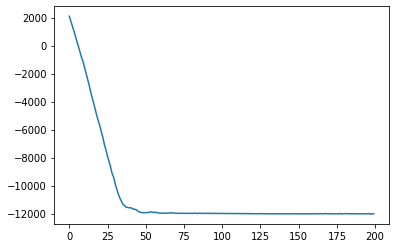

In [40]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=demand_model.joint_log_prob(
        observed_time_series=demand_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(50)

In [41]:
print("Inferred parameters:")
for param in demand_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.004596688707044402 +- 0.00011211925646428785
hour_of_day_effect/_drift_scale: 0.0037278041306291285 +- 0.00018357043009620158
day_of_week_effect/_drift_scale: 0.0030995491435691198 +- 0.0011802525300412914
temperature_effect/_weights: [-0.01817504] +- [0.02282484]
price_effect/_weights: [-0.00833359] +- [0.0047165]
photovoltaic_effect/_weights: [-0.00743032] +- [0.00422443]
autoregressive/_coefficients: [0.96978842] +- [0.00231264]
autoregressive/_level_scale: 0.0305252551056617 +- 0.00022180263807331595


In [42]:
num_forecast_steps = 24 * 7 * 2 # Two weeks.
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=demand_training_data,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)


In [43]:
num_samples=10

(
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples
) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

In [59]:
forecast_steps_df = prepared_data.loc[prepared_data[MEASURE_COLUMN_NAME].apply(isValidationOrTest)]
forecast_steps_df.reset_index(drop=True, inplace=True)
forecast_steps = forecast_steps_df.loc[:(num_forecast_steps - 1),'Time']

0     2012-09-13 00:00:00+00:00
1     2012-09-13 01:00:00+00:00
2     2012-09-13 02:00:00+00:00
3     2012-09-13 03:00:00+00:00
4     2012-09-13 04:00:00+00:00
                 ...           
331   2012-09-26 19:00:00+00:00
332   2012-09-26 20:00:00+00:00
333   2012-09-26 21:00:00+00:00
334   2012-09-26 22:00:00+00:00
335   2012-09-26 23:00:00+00:00
Name: Time, Length: 336, dtype: datetime64[ns, UTC]

break0


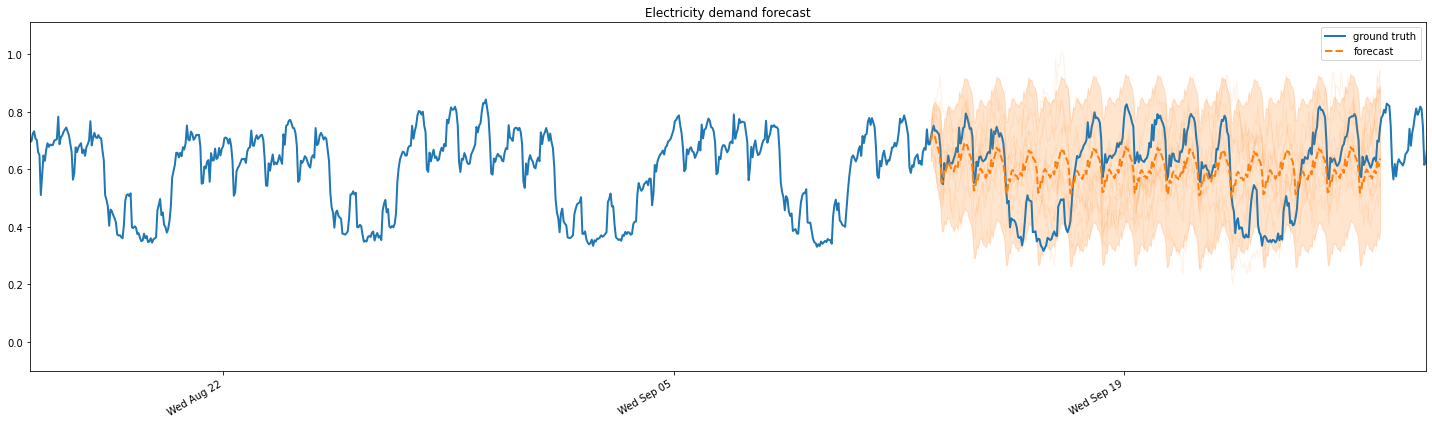

In [93]:
fig, ax = plot_forecast(prepared_data.loc[:,'Time'], prepared_data.loc[:,'Power consumption (kWh)'], forecast_steps,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecast",
                        x_locator=demand_loc, x_formatter=demand_fmt)

train_steps_df = prepared_data.loc[prepared_data[MEASURE_COLUMN_NAME].apply(isTraining)]
ax.set_xlim([train_steps_df.iloc[-(num_forecast_steps*2),:]['Time'], forecast_steps_df.iloc[(int(num_forecast_steps*1.1)),:]['Time']])

fig.tight_layout()

In [94]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    demand_model,
    observed_time_series=demand_training_data,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

In [95]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    demand_forecast_component_means_,
    demand_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

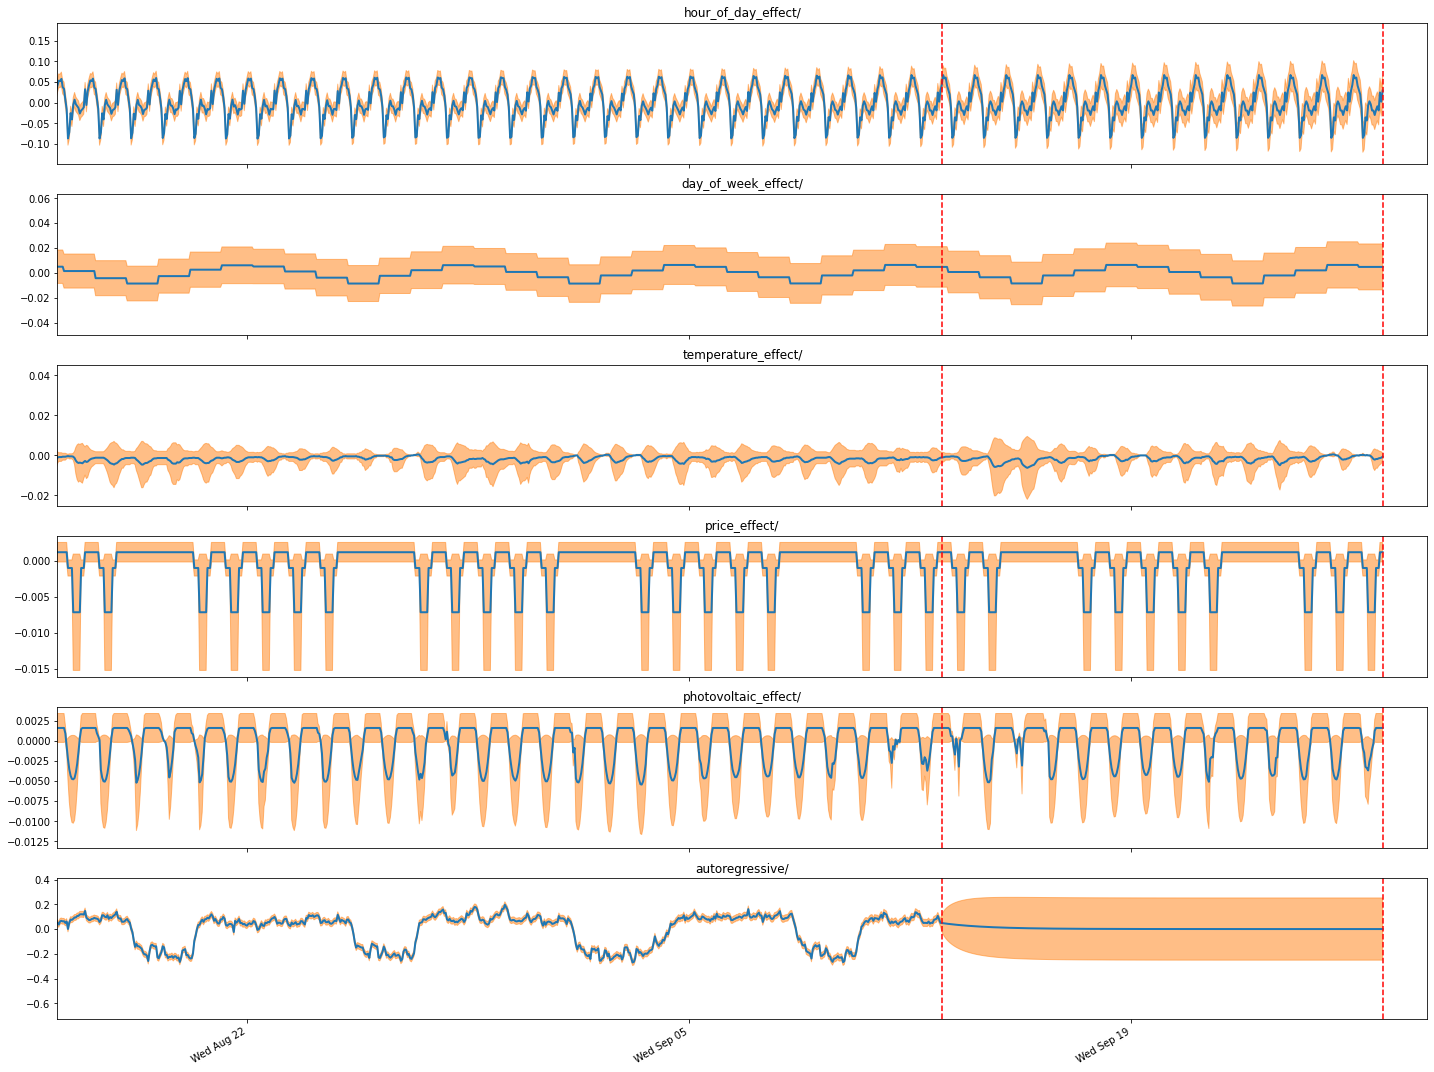

In [134]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  prepared_data.loc[:,'Time'],
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
    ax.axvline(forecast_steps_df.loc[0,'Time'], linestyle="--", color='red')
    ax.axvline(forecast_steps_df.loc[(num_forecast_steps - 1),'Time'], linestyle="--", color='red')
    ax.set_xlim([train_steps_df.iloc[-(num_forecast_steps*2),:]['Time'], forecast_steps_df.iloc[(int(num_forecast_steps*1.1)),:]['Time']])


In [119]:
demand_one_step_dist = sts.one_step_predictive(
    demand_model,
    observed_time_series=prepared_data.loc[:,'Power consumption (kWh)'],
    parameter_samples=q_samples_demand_)

demand_one_step_mean, demand_one_step_scale = (
    demand_one_step_dist.mean().numpy(), demand_one_step_dist.stddev().numpy())

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


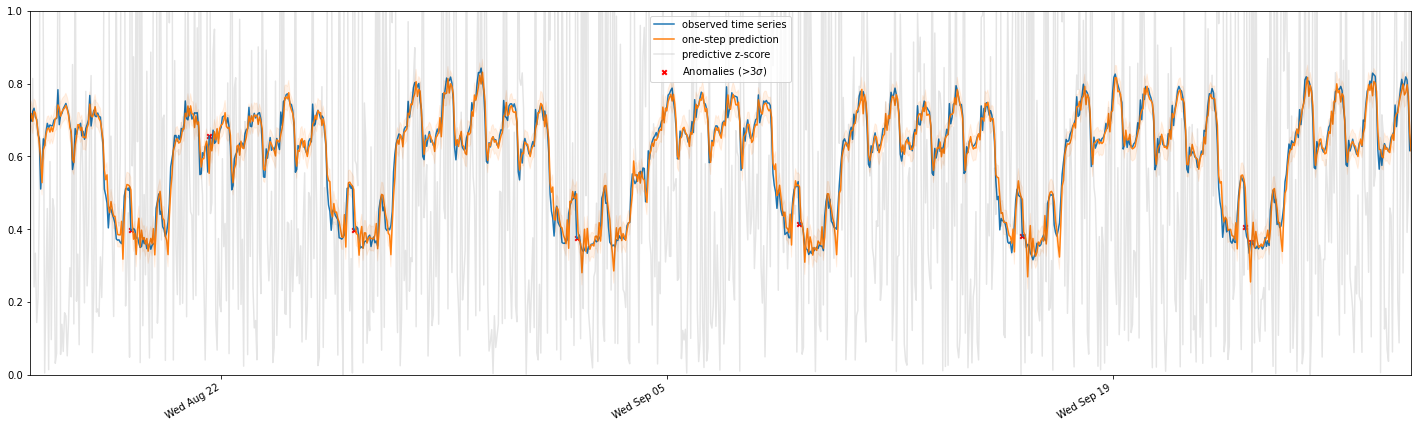

In [132]:
fig, ax = plot_one_step_predictive(
    prepared_data.loc[:,'Time'], prepared_data.loc[:,'Power consumption (kWh)'],
    demand_one_step_mean, demand_one_step_scale,
    x_locator=demand_loc, x_formatter=demand_fmt)

ax.set_ylim(0, 1)
ax.set_xlim([train_steps_df.iloc[-(num_forecast_steps*2),:]['Time'], forecast_steps_df.iloc[(int(num_forecast_steps*1.1)),:]['Time']])

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((prepared_data.loc[:,'Power consumption (kWh)'] - demand_one_step_mean) /
                 demand_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(prepared_data.loc[:,'Time'][anomalies],
           prepared_data.loc[:,'Power consumption (kWh)'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(prepared_data.loc[:,'Time'], zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()